## NAIVE BAYES

In [1]:
%matplotlib inline

# import libraries
import copy
import numpy as np
import scipy as sp
#import matplotlib as mpl
#import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# setup Seaborn
sns.set_style('whitegrid')
sns.set_context('poster')

In [2]:
# machine learning libraries 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

In [45]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
# import data
data_reviews = pd.read_csv('Data_rating_112_airlines_V2.csv')

In [4]:
# make a copy of the data
data_ratings = data_reviews.copy()

In [5]:
# adding second recommended column
data_ratings['recommended_2'] = data_ratings['recommended']

In [6]:
# replace values in recommended_2 column
data_ratings = data_ratings.replace({'recommended_2': {0: 'No', 1: 'Yes'}})

In [7]:
# drop rows with missing content
data_ratings = data_ratings[~data_ratings.content.isnull()]
data_ratings.head()

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended,recommended_2
0,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,P Vlogianitis,Australia,2015-08-01,"Flight to Larnaca was a joy. Generous legroom,...",A321,Family Leisure,Business Class,Athens to Larnaca,10.0,5.0,5.0,5.0,NaN,3.0,NaN,5.0,1,Yes
1,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,Eric Botha,United Kingdom,2015-07-28,"Flight on time, row 1 - Friendly staff and ver...",A321,Couple Leisure,Business Class,Athens to London,8.0,4.0,5.0,4.0,2.0,4.0,NaN,4.0,1,Yes
2,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,Nathan Vermeulen,Belgium,2015-07-26,Very good flight with Aegean. The boarding was...,A320-232,Family Leisure,Economy,Brussels to Heraklion,9.0,4.0,5.0,4.0,NaN,4.0,NaN,4.0,1,Yes
3,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,N Sunder,United States,2015-07-21,"Brand new A320, interior spotless. Crew immacu...",A320,Solo Leisure,Economy,Mykonos to Athens,8.0,4.0,4.0,NaN,NaN,4.0,NaN,4.0,1,Yes
4,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,Dimitrios Chrysos-Gklavas,Greece,2015-07-21,I booked a premium economy ticket so I can hav...,Dash 8 Q400,Solo Leisure,Economy,Athens to Santorini,8.0,4.0,5.0,4.0,NaN,2.0,NaN,3.0,1,Yes


### 1. DATA EXPLORATION

In [8]:
# get more information about columns in dataframe
data_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35609 entries, 0 to 35608
Data columns (total 21 columns):
airline_name                     35609 non-null object
link                             35609 non-null object
title                            35609 non-null object
author                           35609 non-null object
author_country                   35396 non-null object
date                             35609 non-null object
content                          35609 non-null object
aircraft                         1153 non-null object
type_traveller                   2164 non-null object
cabin_flown                      34138 non-null object
route                            2128 non-null object
overall_rating                   32275 non-null float64
seat_comfort_rating              31415 non-null float64
cabin_staff_rating               31417 non-null float64
food_beverages_rating            31020 non-null float64
inflight_entertainment_rating    28980 non-null float64
ground_se

In [9]:
# check number of reviews, number of authors and number of airlines
n_reviews = len(data_ratings)
n_airlines = data_ratings.airline_name.unique().size
n_authors = data_ratings.author.unique().size


print('Number of reviews: {:d}'.format(n_reviews))
print('Number of authors: {:d}'.format(n_authors))
print('Number of airlines:  {:d}'.format(n_airlines))

Number of reviews: 35609
Number of authors: 25938
Number of airlines:  112


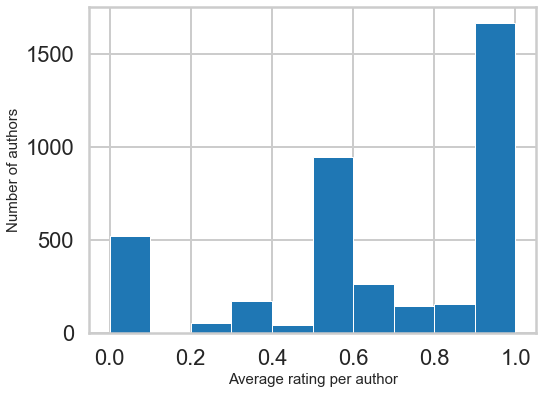

In [10]:
# create a copy of dataframe
df_copy = data_ratings.copy()

# change values in recommended_2 column to True if the value is Yes and False if it isn't
df_copy['recommended_2'] = df_copy.recommended_2 == 'Yes'

# group dataframe by author
grouped_author = df_copy.groupby('author')

# number of reviews by each author
grouped_author_counts = grouped_author.author.count()

# average recommended rating for each author
grouped_author_means = grouped_author.recommended_2.mean()     

# plot a histogram for authors with more than 1 review
grouped_author_means[grouped_author_counts > 1].hist(bins=10, edgecolor='w', lw=1, figsize=(8,6))
plt.xlabel('Average rating per author', fontsize=15)
plt.ylabel('Number of authors', fontsize=15)
plt.show()

By looking at the histogram, we can see that many authors on average recommended an airline they flew with. And on average around 500 authors didn't recommend an airline. Around 900 authors gave on average half the time recommended rate 1 and half the time rate 0. 

### 2. PREPARING DATA

In [47]:
# create a copy of dataframe
data_ratings_copy = data_ratings.copy()

# change reviews into lower case text
data_ratings_copy['content'] = data_ratings_copy['content'].str.lower()

# tokenization
def identify_tokens(row):
    review = row['content']
    tokens = word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

data_ratings_copy['content'] = data_ratings_copy.apply(identify_tokens, axis=1)

In [48]:
# lemmatizer
word_lemma = WordNetLemmatizer()
def lemmatize(row):
    my_list = row['content']
    lemma = [word_lemma.lemmatize(word) for word in my_list]
    return (lemma)

data_ratings_copy['content'] = data_ratings_copy.apply(lemmatize, axis=1)

In [49]:
# remove stop words
stops = set(stopwords.words('english'))                  

def remove_stops(row):
    my_list = row['content']
    meaningful_words = [w for w in my_list if not w in stops]
    return meaningful_words

data_ratings_copy['content'] = data_ratings_copy.apply(remove_stops, axis=1)

In [50]:
# remove list from column and print first few rows
data_ratings_copy['content'] = data_ratings_copy.content.apply(', '.join)
data_ratings_copy.head()

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended,recommended_2
0,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,P Vlogianitis,Australia,2015-08-01,"flight, larnaca, wa, joy, generous, legroom, n...",A321,Family Leisure,Business Class,Athens to Larnaca,10.0,5.0,5.0,5.0,NaN,3.0,NaN,5.0,1,Yes
1,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,Eric Botha,United Kingdom,2015-07-28,"flight, time, row, friendly, staff, attentive,...",A321,Couple Leisure,Business Class,Athens to London,8.0,4.0,5.0,4.0,2.0,4.0,NaN,4.0,1,Yes
2,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,Nathan Vermeulen,Belgium,2015-07-26,"good, flight, aegean, boarding, wa, quickly, c...",A320-232,Family Leisure,Economy,Brussels to Heraklion,9.0,4.0,5.0,4.0,NaN,4.0,NaN,4.0,1,Yes
3,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,N Sunder,United States,2015-07-21,"brand, new, interior, spotless, crew, immacula...",A320,Solo Leisure,Economy,Mykonos to Athens,8.0,4.0,4.0,NaN,NaN,4.0,NaN,4.0,1,Yes
4,aegean-airlines,/airline-reviews/aegean-airlines,Aegean Airlines customer review,Dimitrios Chrysos-Gklavas,Greece,2015-07-21,"booked, premium, economy, ticket, suitcase, on...",Dash 8 Q400,Solo Leisure,Economy,Athens to Santorini,8.0,4.0,5.0,4.0,NaN,2.0,NaN,3.0,1,Yes


### 3. MULTINOMINAL NAIVE BAYES

In [51]:
# define X and y from dataframe
def make_xy(data_ratings_copy, vectorizer=None):   
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data_ratings_copy.content)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (data_ratings_copy.recommended_2 == 'Yes').values.astype(np.int)
    return X, y
X, y = make_xy(data_ratings_copy)

In [52]:
# split the dataframe into a training and test set
xtrain_1, xtest_1, ytrain_1, ytest_1 = train_test_split(X, y)

In [53]:
# use `scikit-learn`'s `MultinomialNB()` classifier with default parameters
clf = MultinomialNB()

# train the classifier over the training set
clf.fit(xtrain_1, ytrain_1)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [54]:
# test on the test set
predict_1 = clf.predict(xtest_1)

In [55]:
# print the accuracy scores for both the training and the test sets
print('Accuracy on training set: ', clf.score(xtrain_1, ytrain_1))
print('Accuracy on test set: ', clf.score(xtest_1, ytest_1))

Accuracy on training set:  0.8686811952370254
Accuracy on test set:  0.8507244748961025


In [818]:
# calculate ROC AUC from predictions
print('ROC AUC score: ', metrics.roc_auc_score(ytest_1, predict_1))

ROC AUC score:  0.8474307199660436


In [821]:
# print confusion matrix 
print(confusion_matrix(ytest_1, predict_1))

[[3305  800]
 [ 529 4269]]


#### 3.1 Picking hyperparameters for Naive Bayes and text maintenance

In [56]:
# create a list of word count
doc_freq = sorted((X > 0).sum(axis=0).tolist()[0])

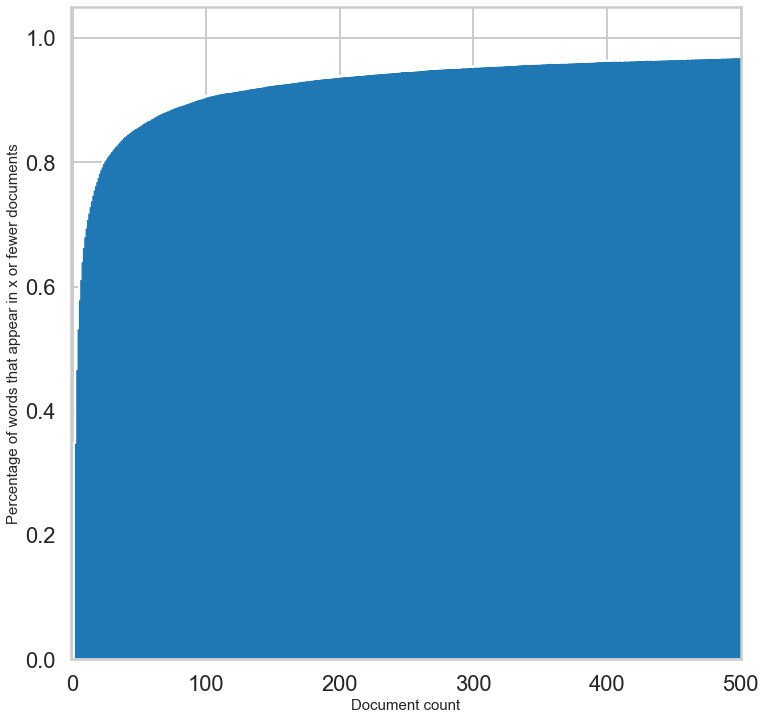

In [57]:
# plot the cumulative distribution of document frequencies
plt.figure(figsize=(12,12))
_ = plt.hist(pd.Series(doc_freq), np.arange(pd.Series(doc_freq).sum()), cumulative=True, histtype='stepfilled', density=True)
_ = plt.xlabel('Document count', fontsize=15)
_ = plt.ylabel('Percentage of words that appear in x or fewer documents', fontsize=15)
_ = plt.xlim(-1, 500)
plt.show()

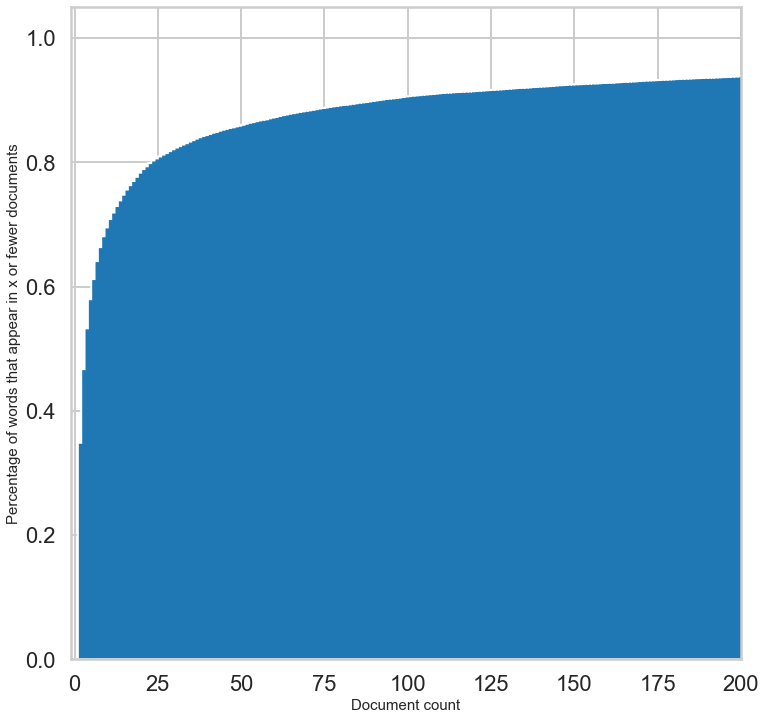

In [58]:
# plot the  cumulative distribution of document frequencies on a smaller scale
plt.figure(figsize=(12,12))
_ = plt.hist(pd.Series(doc_freq), np.arange(pd.Series(doc_freq).sum()), cumulative=True, histtype='stepfilled', density=True)
_ = plt.xlabel('Document count', fontsize=15)
_ = plt.ylabel('Percentage of words that appear in x or fewer documents', fontsize=15)
_ = plt.xlim(-1, 200)
plt.show()

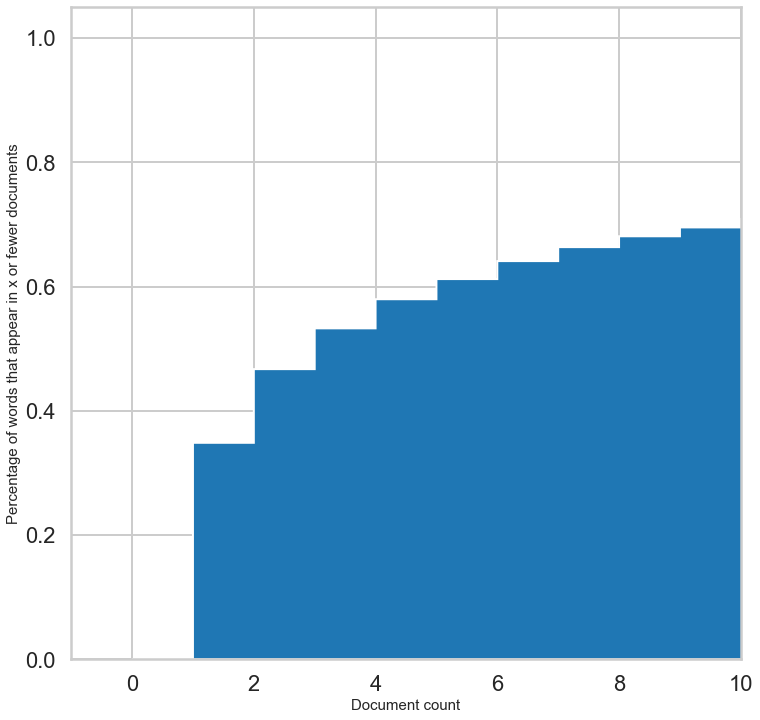

In [59]:
# plot the  cumulative distribution of document frequencies on a smaller scale
plt.figure(figsize=(12,12))
_ = plt.hist(pd.Series(doc_freq), np.arange(pd.Series(doc_freq).sum()), cumulative=True, histtype='stepfilled', density=True)
_ = plt.xlabel('Document count', fontsize=15)
_ = plt.ylabel('Percentage of words that appear in x or fewer documents', fontsize=15)
_ = plt.xlim(-1, 10)
plt.show()

If we look at the above graphs, we can see that at x=2 the curve begins climbing steeply, this could be our value for best 'min_df'. 

In [60]:
# create a score function
# the function cv_score performs the K-fold cross-validation algorithm
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed in as clf
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold #  return the average

In [61]:
# define the log-likelihood function
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    No = y == 0
    Yes = ~No
    return prob[No, 0].sum() + prob[Yes, 1].sum()

In [62]:
# set up the train and test masks
_, itest = train_test_split(range(data_ratings_copy.shape[0]), train_size=0.7)
mask = np.zeros(data_ratings_copy.shape[0], dtype=np.bool)
mask[itest] = True

In [63]:
# the grid of parameters to search over
alphas_2 = [.1, 1, 5, 10, 50]
best_min_df_2 = 2 # value we chose from plotted histogram above

# find the best value for alpha and min_df, and the best classifier
best_alpha_2 = None
maxscore_2 = -np.inf
for alpha in alphas_2:        
    vectorizer_2 = CountVectorizer(min_df=best_min_df_2)       
    Xthis_2, ythis_2 = make_xy(data_ratings_copy, vectorizer_2)
    Xtrainthis_2 = Xthis_2[mask]
    ytrainthis_2 = ythis_2[mask]
    clf_2 = MultinomialNB(alpha=alpha)
    score_2 = cv_score(clf_2, Xtrainthis_2, ytrainthis_2, log_likelihood)
    print('alpha:', alpha, 'score:', score_2)
    if score_2 > maxscore_2:
        maxscore_2 = score_2
        best_alpha_2 = alpha
print('With min_df = 1, the best alpha is:', best_alpha_2 ,'and has max score:', maxscore_2)

alpha: 0.1 score: -2790.582395111561
alpha: 1 score: -2495.7748354473383
alpha: 5 score: -2298.064478312791
alpha: 10 score: -2189.240469845062
alpha: 50 score: -1906.953493330831
With min_df = 1, the best alpha is: 50 and has max score: -1906.953493330831


In [64]:
# the grid of parameters to search over
alphas = [0, 0.1, 1, 5, 10, 50]
min_dfs = [0.001, 0.01, 0.1, 1, 2, 3, 5, 10, 15, 20, 50, 80] 

# find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None 
maxscore = -np.inf

for alpha in alphas: 
    for min_df in min_dfs: 
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy(data_ratings_copy, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf_IV = MultinomialNB(alpha = alpha)
        cvscore = cv_score(clf_IV, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha = alpha 
            best_min_df = min_df

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e'

In [65]:
# print calculated best values
print('alpha: {}'.format(best_alpha))
print('best min_df: {}'.format(best_min_df))
print('best score: {}'.format(maxscore))

alpha: 50
best min_df: 0.1
best score: -1342.8486029583719


### 3.2. Model with the best parameters

In [66]:
# make a model from the best parameters
vectorizer_3 = CountVectorizer(min_df=best_min_df)
X, y = make_xy(data_ratings_copy, vectorizer_3)
xtrain_2 = X[mask]
ytrain_2 = y[mask]
xtest_2 = X[~mask]
ytest_2 = y[~mask]

clf_3 = MultinomialNB(alpha=best_alpha).fit(xtrain_2, ytrain_2)

# print the accuracy on the test and training dataset
training_accuracy_3 = clf_3.score(xtrain_2, ytrain_2)
test_accuracy_3 = clf_3.score(xtest_2, ytest_2)

print('Accuracy on training data: {:2f}'.format(training_accuracy_3))
print('Accuracy on test data:     {:2f}'.format(test_accuracy_3))

Accuracy on training data: 0.773378
Accuracy on test data:     0.781714


In [817]:
# calculate ROC AUC from predictions
print('ROC AUC score: ', metrics.roc_auc_score(ytest_2, clf_3.predict(xtest_2)))

ROC AUC score:  0.7772500298567327


#### 3.2.1. The confusion matrix

In [67]:
# print confusion matrix 
print(confusion_matrix(ytest_2, clf_3.predict(xtest_2)))

[[ 8259  3113]
 [ 2328 11226]]


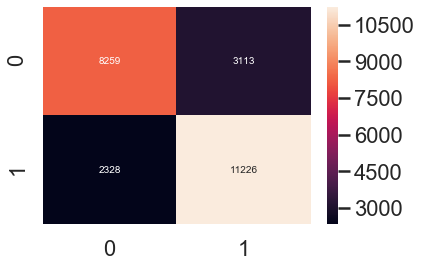

In [68]:
# plot the confusion matrix
sns.heatmap(confusion_matrix(ytest_2, clf_3.predict(xtest_2)), annot=True, fmt='d')

True Positive = 11226 (Observation is positive, and is predicted to be positive. Number of instances of positive class '1' correctly predicted.)

True Negative = 8259 (Observation is negative, and is predicted to be negative. Number of instances of negative class '0' correctly predicted.)

False Positive = 3113 (Observation is negative, but is predicted positive. Number of instances of negative class '0' incorrectly predicted as the positive class '1'.)

False Negative = 2328 (Observation is positive, but is predicted negative. Number of instances of positive class '1' incorrectly predicted as the negative class '0'.)

#### 3.2.2. Evaluating the precision and recall metric for our training data

In [69]:
# instantiate the classifier
nb_classifier = MultinomialNB(alpha=best_alpha)

# fit to the training data
nb_classifier.fit(xtrain_2, ytrain_2)

# predict the labels
pred_labels = nb_classifier.predict(xtest_2)

In [70]:
# create a machine learning pipelines
pipe_NB = make_pipeline(MultinomialNB())

In [71]:
# compute predicted y's
predicted_NB = cross_val_predict(pipe_NB, X, y, cv=3, n_jobs=-1)

In [816]:
# calculate ROC AUC from predictions
print('ROC AUC score: ', metrics.roc_auc_score(y, predicted_NB))

ROC AUC score:  0.7716870130849468


Let's check the Text summary of the precision, recall, F1 score for each recommended rating class (0, 1). 

A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. More specifically, True Positives, False Positives, True Negatives and False Negatives are used to predict the metrics of a classification report as shown below. 

In [72]:
# classification report
print('Multinomial Naive Bayes:') 
print(classification_report(y, predicted_NB)) 
print('\n')

Multinomial Naive Bayes:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75     16231
           1       0.78      0.83      0.80     19378

    accuracy                           0.78     35609
   macro avg       0.78      0.77      0.77     35609
weighted avg       0.78      0.78      0.78     35609





First, let's refresh the meaning of each parameter in the report:
The precision is the ratio between the number of true positives and the number of false positives. Precision is the ability of a classifier not to label an instance positive that is actually negative.

The recall is the ratio between the number of true positives and the number of false negatives. Recall is the ability of a classifier to find all positive instances.

The F-beta score can be interpreted as a weighted harmonic mean of precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_true (correct target values).

The reported averages include macro average, which represents averaging the unweighted mean per label. And weighted average, which is averaging the support-weighted mean per label.

The precision and recall rates give us an idea about the discriminative ability of our classifier. In this case our average precision and recall rates are both 0.78. But if we look for each class, we can see that recall is higher for class 1 (travellers recommended airline).
For the accuracy we get the similar result as we did above for the accuracy on the training set (in cell 66).



#### 3.2.3. What are the strongly predictive features?

In [73]:
# find good and bad words from the model with best parameters
words_1 = np.array(vectorizer_3.get_feature_names())

h = np.eye(xtest_2.shape[1])
probs = clf_3.predict_log_proba(h)[:, 0]
ind = np.argsort(probs)

good_words = words_1[ind[:10]]
bad_words = words_1[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print('Good words\t     P(Yes | word)')
for w, p in zip(good_words, good_prob):
    print('{:>20}'.format(w), '{:.2f}'.format(1 - np.exp(p)))
    
print('Bad words\t     P(Yes | word)')
for w, p in zip(bad_words, bad_prob):
    print('{:>20}'.format(w), '{:.2f}'.format(1 - np.exp(p)))

Good words	     P(Yes | word)
           excellent 0.90
         comfortable 0.83
               great 0.83
            friendly 0.82
                nice 0.82
                good 0.81
                well 0.69
                 new 0.68
               cabin 0.65
                crew 0.64
Bad words	     P(Yes | word)
               could 0.41
                 got 0.40
               delay 0.39
                 get 0.37
                next 0.36
                 day 0.33
                hour 0.33
             delayed 0.31
               never 0.24
                told 0.15


By looking at both categories of words, we can say that our classifier did correctly identified them. Words like 'excellent', 'great', 'nice', are definitely good/positive words. On the other hand, 'delay' and 'never' are words that are not associated with something good.

#### 3.2.4. Prediction errors

We can see mis-predictions as well:

In [74]:
x, y = make_xy(data_ratings_copy, vectorizer_3)

prob = clf_3.predict_proba(x)[:, 0]
predict = clf_3.predict(x)

bad_no = np.argsort(prob[y == 0])[:5]
bad_yes = np.argsort(prob[y == 1])[-5:]

print('Mis-predicted Not recommended quotes')
print('---------------------------')
for row in bad_no:
    print(data_ratings_copy[y == 0].content.iloc[row])
    print("")

print('Mis-predicted Yes recommended quotes')
print('--------------------------')
for row in bad_yes:
    print(data_ratings_copy[y == 1].content.iloc[row])
    print('')

Mis-predicted Not recommended quotes
---------------------------
leg, airbus, club, europe, business, class, leg, time, seat, economy, seat, middle, seat, left, unsold, featuring, new, slim, seat, le, comfortable, reduced, seat, pitch, li, wa, handled, rather, surly, agent, wa, untypical, otherwise, friendly, airport, business, class, waiting, line, short, overall, wa, leg, wa, rather, lacklustre, inattentive, european, fleet, crew, initial, service, food, drink, service, consisted, clearing, dish, board, sale, business, class, flight, attendant, behind, curtain, reading, magazine, chatting, rather, attending, passenger, business, class, food, served, wa, plate, cold, cut, roll, three, thin, slice, fruit, basically, make, sandwich, plate, extremely, disappointing, poor, lunch, flight, scheduled, arrive, heathrow, pm, leg, service, wa, afternoon, tea, meaning, sandwich, however, time, least, wa, appropriate, due, time, day, full, bar, service, flight, french, white, wine, served, wa, mi

### 4. TERM-FREQUENCY x INVERSE DOCUMENT FREQUENCY

We can use Tfidfvectorizer to compute tf-idf scores on documents within our training dataset.

With Tfidfvectorizer we compute the word counts, idf and tf-idf values all at once:

In [77]:
# initiate TfidfVectorizer to get the tf-idf scores of a set of documents
tfidf_vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf = tfidf_vectorizer.fit_transform(data_ratings_copy.content)

In [78]:
# check the shape 
print(Xtfidf.shape)

(35609, 22662)


Now let’s print the tfidf values for the first document from our collection:

In [79]:
# print the first document from our dataset
data_ratings_copy.content.iloc[0]

'flight, larnaca, wa, joy, generous, legroom, nice, meal, fantastic, range, drink, choose, crew, wa, attentive, nice, aegean, leave, cockpit, door, open'

In [80]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer = Xtfidf[0]
 
# place tf-idf values in a pandas dataframe
df_Xtfidf = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=['tfidf'])
df_Xtfidf.sort_values(by=['tfidf'], ascending=False)

,tfidf
larnaca,0.341738
joy,0.331779
aegean,0.313533
cockpit,0.296763
nice,0.296642
range,0.264392
generous,0.258298
door,0.234512
open,0.228498
fantastic,0.220248


What we can notice that only certain words have scores. This is because our first document, printed above, has all the words that have a tf-idf score and everything else show up as zeroes. Words like 'a' or 'and' are missing from this list, because stop words are removed during processing.

The scores above make sense. The more common the word across documents, the lower its score and the more unique a word is to our first document (e.g. ‘larnaca’ and ‘aegean’) the higher the score.

### 5. MODEL SELECTION 

We can also experiment with different machine learning models and evaluate their 'area under curve' score.

We will use the following three models:

    (Multinomial) Naive Bayes
    Linear Support Vector Machine
    Random Forest

In [85]:
# define labels and features
features_Xt = Xtfidf.toarray()
labels_Xt = data_ratings_copy.recommended
features_Xt.shape

(35609, 22662)

In [87]:
# cros validate selected classifiers
models = [
    RandomForestClassifier(),
    LinearSVC(),
    MultinomialNB()
#    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    auc_Xt = cross_val_score(model, features_Xt, labels_Xt, scoring='roc_auc', cv=CV)
    for fold_idx, auc in enumerate(auc_Xt):
        entries.append((model_name, fold_idx, auc))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'roc_auc'])


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/si

In [88]:
# print the scoring dataframe with results
cv_df

,model_name,fold_idx,roc_auc
0,RandomForestClassifier,0,0.895426
1,RandomForestClassifier,1,0.878161
2,RandomForestClassifier,2,0.891623
3,RandomForestClassifier,3,0.903656
4,RandomForestClassifier,4,0.892179
5,LinearSVC,0,0.948371
6,LinearSVC,1,0.936337
7,LinearSVC,2,0.932137
8,LinearSVC,3,0.933093
9,LinearSVC,4,0.944574


In [89]:
# print the score mean for each model
cv_df.groupby('model_name').roc_auc.mean()

model_name
LinearSVC                 0.938902
MultinomialNB             0.916259
RandomForestClassifier    0.892209
Name: roc_auc, dtype: float64

From this results we can see that on average LinearSVC model performed better than the other two classifiers. Now, let's build few models with LinearSVC and RandomForest classifiers.

#### 5.1 Random Forest

In [99]:
# split dataset into training set and test set, 70% training and 30% test, features and labels are from cell 85
X_train, X_test, y_train, y_test = train_test_split(features_Xt, labels_Xt, test_size=0.3)

Let's first build a model on a smaller dataset by useing just first 100 rows.

In [105]:
# first 100 rows
X_train_100 = X_train[:100]
X_test_100 = X_test[:100]
y_train_100 = y_train[:100]
y_test_100 = y_test[:100]

In [134]:
# instantiate model 
rand_forest = RandomForestClassifier()

# train the model on training data
rand_forest.fit(X_train_100, y_train_100)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [135]:
# use the forest's predict method on the test data
rand_forest_pred = rand_forest.predict(X_test_100)

In [136]:
# printing the first 6 values of y_test and the predicted results target
for i in range(0, 6):
    print('Actual recommended rating: {} and Predicted recommended rating: {}'.format(list(y_test_100)[i], rand_forest_pred[i]))

Actual recommended rating: 0 and Predicted recommended rating: 1
Actual recommended rating: 1 and Predicted recommended rating: 1
Actual recommended rating: 1 and Predicted recommended rating: 1
Actual recommended rating: 1 and Predicted recommended rating: 1
Actual recommended rating: 1 and Predicted recommended rating: 1
Actual recommended rating: 1 and Predicted recommended rating: 1


In [137]:
# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_100, rand_forest_pred))

ROC AUC score:  0.6044471644226846


In [139]:
# calculate F1 score from prediction scores
print('f1_score: ', metrics.f1_score(y_test_100, rand_forest_pred))

f1_score:  0.7517730496453902


In [152]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_100, rand_forest_pred))

[[12 31]
 [ 4 53]]


True positive: 53, true negative: 12, false positive: 31, false negative: 4.

Now build Random Forest model on the whole dataset:

In [131]:
# instantiate model 
rand_forest_all = RandomForestClassifier()

# train the model on training data
rand_forest_all.fit(X_train, y_train)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [132]:
# use the forest's predict method on the test data
rand_forest_all_pred = rand_forest_all.predict(X_test)

In [133]:
# printing the first 6 values of y_test and the predicted results target
for i in range(0, 6):
    print('Actual recommended rating: {} and Predicted recommended rating: {}'.format(list(y_test)[i], rand_forest_all_pred[i]))

Actual recommended rating: 0 and Predicted recommended rating: 1
Actual recommended rating: 1 and Predicted recommended rating: 0
Actual recommended rating: 1 and Predicted recommended rating: 1
Actual recommended rating: 1 and Predicted recommended rating: 1
Actual recommended rating: 1 and Predicted recommended rating: 1
Actual recommended rating: 1 and Predicted recommended rating: 1


In [140]:
# calculate ROC AUC from predictions
print('ROC AUC score: ', metrics.roc_auc_score(y_test, rand_forest_all_pred))

ROC AUC score:  0.8153164751944824


In [142]:
# calculate F1 score from predictions
print('f1_score: ', metrics.f1_score(y_test, rand_forest_all_pred))

f1_score:  0.827898866608544


In [151]:
# print confusion matrix
print(metrics.confusion_matrix(y_test, rand_forest_all_pred))

[[3961  891]
 [1083 4748]]


True positive: 4748, true negative: 3961, false positive: 891, false negative: 1083.

#### 5.2. LinearSVC

Let's first build a model on a smaller sample (100 rows):

In [117]:
# create a LinearSVC instance and fit the training data
classifier_linear = LinearSVC()

model_linear = classifier_linear.fit(X_train_100, y_train_100)

In [118]:
# predict on the test data
y_test_linear = model_linear.predict(X_test_100)

In [124]:
# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_100, y_test_linear))

ROC AUC score:  0.65687474500204


In [128]:
# calculate F1 score from prediction scores
print('f1_score: ', metrics.f1_score(y_test_100, y_test_linear))

f1_score:  0.7857142857142856


In [150]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_100, y_test_linear))

[[15 28]
 [ 2 55]]


True positive: 55, true negative: 15, false positive: 28, false negative: 2

Now, we can also build a model on  a whole dataset:

In [143]:
# create a LinearSVC instance and fit the training data
classifier_linear_all = LinearSVC()

model_linear_all = classifier_linear_all.fit(X_train, y_train)

In [145]:
# predict on the test data
y_test_linear_all = model_linear_all.predict(X_test)

In [146]:
# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test, y_test_linear_all))

ROC AUC score:  0.884595022793006


In [147]:
# calculate F1 score from prediction scores
print('f1_score: ', metrics.f1_score(y_test, y_test_linear_all))

f1_score:  0.8945285615966965


In [149]:
# print confusion matrix
print(metrics.confusion_matrix(y_test, y_test_linear_all))

[[4258  594]
 [ 632 5199]]


True positive: 5199, true negative: 4258, false positive: 594, false negative: 632

### 6. PIPLINES

#### 6.1. Simple pipelines

Let's first take a small sample of 100 rows from dataset:

In [219]:
# select 100 rows from the dataframe
data_100 = data_ratings_copy.iloc[:100]

In [221]:
# check the length of the new dataframe
data_100.shape

(100, 21)

In [235]:
# split data into training and test, only using 'content' column as an independable feature and 'recommended' as dependable
data_train_T100, data_test_T100, y_train_T100, y_test_T100 = train_test_split(data_100['content'], data_100['recommended'], test_size=0.3)

In [236]:
# create a pipeline to preprocess the data and instance for classifier
clf_svc_100 = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english')),
                    ('clf', LinearSVC()),
                    ])

# fit the selected classifier with training data and predict on test 
model_clf_svc_100 = clf_svc_100.fit(data_train_T100, y_train_T100)
predicted_svc_100 = model_clf_svc_100.predict(data_test_T100)

In [238]:
# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_T100, predicted_svc_100))

ROC AUC score:  0.6


In [237]:
print(np.mean(predicted_svc_100 == y_test_T100))

0.8666666666666667


Now, let's build a simple pipeline with Random Forest classifier.

In [233]:
# create a pipeline to preprocess the data and an instance for classifier
clf_svc_100_rd = Pipeline([
                    ('tfidf_100', TfidfVectorizer(stop_words='english')),
                    ('rdc_100', RandomForestClassifier()),
                    ])

# fit the selected classifier with training data and predict on test
model_clf_svc_100_rd = clf_svc_100_rd.fit(data_train_T100, y_train_T100)
predicted_svc_100_rd = model_clf_svc_100_rd.predict(data_test_T100)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [239]:
# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_T100, predicted_svc_100_rd))

ROC AUC score:  0.4


Let's check how will both classifiers perform on the whole dataset:

In [244]:
# split data into training and test
data_train_all, data_test_all, y_train_all, y_test_all = train_test_split(data_ratings_copy['content'], data_ratings_copy['recommended'], test_size=0.3)

In [245]:
# create a pipeline to preprocess the data and an instance for classifier
clf_svc_all_linear = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english')),
                    ('clf', LinearSVC()),
                    ])

# fit the selected classifier with training data and predict on test
model_clf_svc_all_linear = clf_svc_all_linear.fit(data_train_all, y_train_all)
predicted_svc_all_linear = model_clf_svc_all_linear.predict(data_test_all)

In [246]:
# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_all, predicted_svc_all_linear))

ROC AUC score:  0.8851564127395597


In [ ]:
We can see that LinearSVC performs much better on the larger dataset.

In [247]:
# create a pipeline to preprocess the data and an instance for classifier
clf_svc_all_rf = Pipeline([
                    ('tfidf_all', TfidfVectorizer(stop_words='english')),
                    ('rdc_all', RandomForestClassifier()),
                    ])

# fit the selected classifier with training data and predict on test
model_clf_svc_all_rf = clf_svc_all_rf.fit(data_train_all, y_train_all)
predicted_svc_all_rf = model_clf_svc_all_rf.predict(data_test_all)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [248]:
# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_all, predicted_svc_all_rf))

ROC AUC score:  0.8240331100293717


As expected classifier performs better on the larger dataset, but its performance is slightly worse than from LinearSVC.

#### 6.2. Pipelines with FeatureUnion

In [251]:
data_ratings_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35609 entries, 0 to 35608
Data columns (total 21 columns):
airline_name                     35609 non-null object
link                             35609 non-null object
title                            35609 non-null object
author                           35609 non-null object
author_country                   35396 non-null object
date                             35609 non-null object
content                          35609 non-null object
aircraft                         1153 non-null object
type_traveller                   2164 non-null object
cabin_flown                      34138 non-null object
route                            2128 non-null object
overall_rating                   32275 non-null float64
seat_comfort_rating              31415 non-null float64
cabin_staff_rating               31417 non-null float64
food_beverages_rating            31020 non-null float64
inflight_entertainment_rating    28980 non-null float64
ground_se

In [269]:
# sample from the dataset (100 rows)
X_s100 = data_100[['content', 'overall_rating', 'seat_comfort_rating', 'cabin_staff_rating', 'value_money_rating', 'food_beverages_rating']]
y_s100 = data_100.recommended

In [624]:
# change float data into integer type
X_s100.value_money_rating = X_s100.value_money_rating.astype(int)

/anaconda3/envs/statenv/lib/python3.6/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [633]:
# change float data into integer type
X_s100.seat_comfort_rating = X_s100.seat_comfort_rating.astype(int)
X_s100.cabin_staff_rating = X_s100.cabin_staff_rating.astype(int)

/anaconda3/envs/statenv/lib/python3.6/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [634]:
# get info on dataframe
X_s100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 6 columns):
content                  100 non-null object
overall_rating           95 non-null float64
seat_comfort_rating      100 non-null int64
cabin_staff_rating       100 non-null int64
value_money_rating       100 non-null int64
food_beverages_rating    95 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 10.5+ KB


In [635]:
# check first few rows
X_s100.head()

,content,overall_rating,seat_comfort_rating,cabin_staff_rating,value_money_rating,food_beverages_rating
0,"flight, larnaca, wa, joy, generous, legroom, n...",10.0,5,5,5,5.0
1,"flight, time, row, friendly, staff, attentive,...",8.0,4,5,4,4.0
2,"good, flight, aegean, boarding, wa, quickly, c...",9.0,4,5,4,4.0
3,"brand, new, interior, spotless, crew, immacula...",8.0,4,4,4,NaN
4,"booked, premium, economy, ticket, suitcase, on...",8.0,4,5,3,4.0


In [637]:
# function for selecting column from the dataframe
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X_s100, y_s100 =None):
        return self
    def transform(self, X_s100):
        return X_s100[[self.field]]

In [638]:
# split the data into train and test
X_train_s100, X_test_s100, y_train_s100, y_test_s100 = train_test_split(X_s100, y_s100, test_size=0.3, random_state=21)

In [640]:
# build a pipeline with selected columns, you want to use as independent features, and instance for a classifier
pipeline_value_seat_cabin = Pipeline([
        ('features', FeatureUnion([
                                    ('f1', NumberSelector('value_money_rating')),
                                    ('f2', NumberSelector('seat_comfort_rating')),
                                    ('f3', NumberSelector('cabin_staff_rating')),
            ])),
        ('clf_f', LinearSVC()),
])

In [641]:
# KFold cross validation with 5 folds
# applying the classifier pipeline to the features and target data
cv_result_value_seat_cabin = cross_val_score(pipeline_value_seat_cabin, X_train_s100, y_train_s100, cv=5)

# print score
print(cv_result_value_seat_cabin)

[0.93333333 1.         0.92857143 0.84615385 0.92307692]


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [719]:
# fit the selected classifier with training data and predict on test
model_value_seat_cabin = pipeline_value_seat_cabin.fit(X_train_s100, y_train_s100)
predicted_value_seat_cabin = model_value_seat_cabin.predict(X_test_s100)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_s100, predicted_value_seat_cabin))

ROC AUC score:  0.9500000000000001


In [798]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_s100, predicted_value_seat_cabin))

[[ 9  1]
 [ 0 20]]


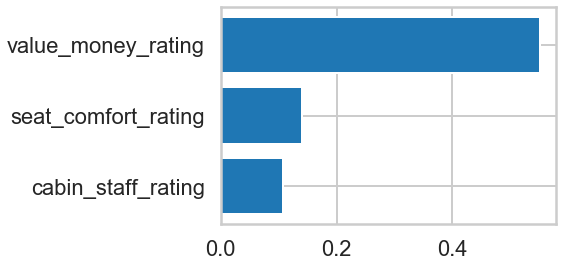

In [795]:
# plot a feature importance 
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = ['value_money_rating', 'seat_comfort_rating', 'cabin_staff_rating']

f_importances(pipeline_value_seat_cabin['clf_f'].coef_[0], features_names)

In [642]:
# build a pipeline with selected columns, you want to use as independent features, and instance for a classifier
pipeline_value_seat_cabin_rf = Pipeline([
        ('features', FeatureUnion([
                                    ('f1', NumberSelector('value_money_rating')), 
                                    ('f2', NumberSelector('seat_comfort_rating')),
                                    ('f3', NumberSelector('cabin_staff_rating')),
            ])),
        ('clf_rf', RandomForestClassifier()),  
])

In [643]:
# KFold cross validation with 5 folds
# applying the classifier pipeline to the features and target data
cv_result_value_seat_cabin_rf = cross_val_score(pipeline_value_seat_cabin_rf, X_train_s100, y_train_s100, cv=5)

# print score
print(cv_result_value_seat_cabin_rf)

[1.         0.93333333 1.         0.84615385 0.92307692]


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/si

In [718]:
# fit the selected classifier with training data and predict on test
model_value_seat_cabin_rf = pipeline_value_seat_cabin_rf.fit(X_train_s100, y_train_s100)
predicted_value_seat_cabin_rf = model_value_seat_cabin_rf.predict(X_test_s100)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_s100, predicted_value_seat_cabin_rf))

ROC AUC score:  0.9500000000000001


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [799]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_s100, predicted_value_seat_cabin_rf))

[[ 9  1]
 [ 0 20]]


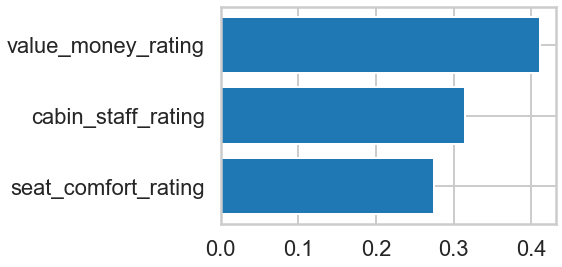

In [790]:
# plot feature importance
features_names = ['value_money_rating', 'seat_comfort_rating', 'cabin_staff_rating']
f_importances(pipeline_value_seat_cabin_rf['clf_rf'].feature_importances_, features_names)

In [424]:
# define features (from string columns) and labels
data_100_few_columns = data_100[['airline_name', 'author_country', 'aircraft', 'type_traveller', 'cabin_flown']]
y_data_100_few_columns = data_100['recommended']

In [442]:
data_100_few_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 5 columns):
airline_name      100 non-null object
author_country    100 non-null object
aircraft          20 non-null object
type_traveller    29 non-null object
cabin_flown       100 non-null object
dtypes: object(5)
memory usage: 9.7+ KB


In [426]:
# function to select column from dataframe
class GetItemTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, data_100_few_columns, y_data_100_few_columns=None):
        return self
    # assume default fit()
    def transform(self, data_100_few_columns):
        return data_100_few_columns[self.field]

In [432]:
# split data into train and test
data_train_few, data_test_few, y_train_few, y_test_few = train_test_split(data_100_few_columns, y_data_100_few_columns, test_size=0.3, random_state=21)

In [431]:
# check length of train and test features and labels
data_train_few.shape, data_test_few.shape, y_train_few.shape, y_test_few.shape

((70, 5), (30, 5), (70,), (30,))

In [488]:
# pipeline with random forest classifier and with airline and cabin flown as independent features
test_airline_cabin_flown_V2 = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer('airline_name')),
                                    ('tfidf', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer('cabin_flown')),
                                    ('tfidf', CountVectorizer(stop_words='english')),
                                    ])),
                            ])),
    ('clf', RandomForestClassifier()),
    ])

In [489]:
# KFold cross validation with 5 folds
# applying the classifier pipeline to the features and target data
cv_result_airline_cabin_rf_V2 = cross_val_score(test_airline_cabin_flown_V2, data_train_few, y_train_few, cv=5)

# print score
print(cv_result_airline_cabin_rf_V2)

[0.73333333 0.66666667 0.78571429 0.76923077 0.69230769]


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/si

In [490]:
# fit the classifier with train data nad predict on test data
model_few_airline_cabin_flown_rf_V2 = test_airline_cabin_flown_V2.fit(data_train_few, y_train_few)
predicted_few_airline_cabin_flown_rf_V2 = model_few_airline_cabin_flown_rf_V2.predict(data_test_few)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [491]:
# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_few, predicted_few_airline_cabin_flown_rf_V2))

ROC AUC score:  0.5


In [800]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_few, predicted_few_airline_cabin_flown_rf_V2))

[[ 0 10]
 [ 0 20]]


In [484]:
# pipeline with LinearSVC classifier and with airline and cabin flown as features
test_airline_cabin_flown_V4 = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer('airline_name')),
                                    ('tfidf', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer('cabin_flown')),
                                    ('tfidf', CountVectorizer(stop_words='english')),
                                    ])),
                            ])),
    ('clf', LinearSVC()),
    ])

In [485]:
# KFold cross validation with 5 folds
# applying the classifier pipeline to the features and target data
cv_result_airline_cabin_linear_V4 = cross_val_score(test_airline_cabin_flown_V4, data_train_few, y_train_few, cv=5)

# print score
print(cv_result_airline_cabin_linear_V4)

[0.73333333 0.73333333 0.78571429 0.76923077 0.76923077]


In [716]:
# fit the selected classifier with training data and predict on test
model_airline_cabin_flown_V4 = test_airline_cabin_flown_V4.fit(data_train_few, y_train_few)
predicted_airline_cabin_flown_V4 = model_airline_cabin_flown_V4.predict(data_test_few)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_few, predicted_airline_cabin_flown_V4))

ROC AUC score:  0.5


In [801]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_few, predicted_airline_cabin_flown_V4))

[[ 0 10]
 [ 0 20]]


In [492]:
# pipeline with LinearSVC classifier with airline cabin flown and author's country as independent features
test_airline_cabin_country_linear = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f3', Pipeline([
                                    ('get', GetItemTransformer('author_country')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ])),
    ('clf', LinearSVC()),
    ])

In [493]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_airline_cabin_country_linear = cross_val_score(test_airline_cabin_country_linear, data_train_few, y_train_few, cv=5)

# print result
print('5 KFold cross validation with LinearSVC classifier: ', cv_result_airline_cabin_country_linear)

5 KFold cross validation with LinearSVC classifier:  [0.6        0.66666667 0.64285714 0.76923077 0.69230769]


To get a good measure of the model’s accuracy, we calculate the mean of the five scores. This is our measure of model accuracy:

In [494]:
# compute average of CV scores
cv_result_airline_cabin_country_linear.mean()

0.6742124542124541

In [715]:
# fit the selected classifier with training data and predict on test
model_airline_cabin_country_linear = test_airline_cabin_country_linear.fit(data_train_few, y_train_few)
predicted_airline_cabin_country_linear = model_airline_cabin_country_linear.predict(data_test_few)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_few, predicted_airline_cabin_country_linear))

ROC AUC score:  0.55


In [802]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_few, predicted_airline_cabin_country_linear))

[[ 1  9]
 [ 0 20]]


In [495]:
# pipeline with Random Forest classifier with airline, cabin flown and author's country as features
test_airline_cabin_country_rf = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f3', Pipeline([
                                    ('get', GetItemTransformer('author_country')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ])),
    ('clf', RandomForestClassifier()),
    ])

In [496]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_airline_cabin_country_rf = cross_val_score(test_airline_cabin_country_rf, data_train_few, y_train_few, cv=5)

# print result
print('5 KFold cross validation with Random Forest classifier: ', cv_result_airline_cabin_country_rf)

5 KFold cross validation with Random Forest classifier:  [0.6        0.66666667 0.71428571 0.69230769 0.53846154]


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/si

In [499]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_airline_cabin_country_rf.mean())

Average value for model's accuracy:  0.6423443223443224


In [714]:
# fit the selected classifier with training data and predict on test
model_airline_cabin_country_rf = test_airline_cabin_country_rf.fit(data_train_few, y_train_few)
predicted_airline_cabin_country_rf = model_airline_cabin_country_rf.predict(data_test_few)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_few, predicted_airline_cabin_country_rf))

ROC AUC score:  0.5249999999999999


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


We can see that that this model has lower average accuracy compare to the LinearSVC classifier.

In [803]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_few, predicted_airline_cabin_country_rf))

[[ 1  9]
 [ 1 19]]


In [646]:
data_100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 21 columns):
airline_name                     100 non-null object
link                             100 non-null object
title                            100 non-null object
author                           100 non-null object
author_country                   100 non-null object
date                             100 non-null object
content                          100 non-null object
aircraft                         20 non-null object
type_traveller                   29 non-null object
cabin_flown                      100 non-null object
route                            29 non-null object
overall_rating                   95 non-null float64
seat_comfort_rating              100 non-null int64
cabin_staff_rating               100 non-null int64
food_beverages_rating            95 non-null float64
inflight_entertainment_rating    81 non-null float64
ground_service_rating            27 non-null float64


In [645]:
# change float type into integer
data_100.seat_comfort_rating = data_100.seat_comfort_rating.astype(int)
data_100.cabin_staff_rating = data_100.cabin_staff_rating.astype(int)
data_100.value_money_rating = data_100.value_money_rating.astype(int)

/anaconda3/envs/statenv/lib/python3.6/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [647]:
# define features and labels for new set of training
data_100_all_columns = data_100.drop(['recommended', 'recommended_2'], axis=1)
data_100_y = data_100.recommended

In [648]:
# split data into training and test set
data_train_100_all, data_test_100_all, y_train_100_all, y_test_100_all = train_test_split(data_100_all_columns, data_100_y, test_size=0.3, random_state=21)

In [649]:
# function to select column from a dataframe
class GetItemTransformer_2(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, data_100_all_columns, data_100_y=None):
        return self
    def transform(self, data_100_all_columns):
        return data_100_all_columns[self.field]

In [654]:
# function to select integer column from a dataframe
class NumberSelector_2(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, data_100_all_columns, data_100_y =None):
        return self
    def transform(self, data_100_all_columns):
        return data_100_all_columns[[self.field]]

In [657]:
# pipeline with LinearSVC classifier with airline and cabin flown as features
test_airline_cabin_money_linear = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer_2('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer_2('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f3', Pipeline([
                                    ('get', NumberSelector_2('value_money_rating')),
                                    ])),
                            ])),
    ('clf', LinearSVC()),
    ])

In [658]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_airline_cabin_money_linear = cross_val_score(test_airline_cabin_money_linear, data_train_100_all, y_train_100_all, cv=5)

# print result
print('5 KFold cross validation with LinearSVC classifier: ', cv_result_airline_cabin_money_linear)

5 KFold cross validation with LinearSVC classifier:  [0.93333333 1.         1.         0.84615385 0.84615385]


In [663]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_airline_cabin_money_linear.mean())

Average value for model's accuracy:  0.9251282051282053


In [713]:
# fit the selected classifier with training data and predict on test
model_airline_cabin_money_linear = test_airline_cabin_money_linear.fit(data_train_100_all, y_train_100_all)
predicted_airline_cabin_money_linear = model_airline_cabin_money_linear.predict(data_test_100_all)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_100_all, predicted_airline_cabin_money_linear))

ROC AUC score:  0.9


In [804]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_100_all, predicted_airline_cabin_money_linear))

[[ 9  1]
 [ 2 18]]


In [659]:
# pipeline with Random Forest classifier and with airline and cabin flown as features
test_airline_cabin_money_rf = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer_2('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer_2('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f3', Pipeline([
                                    ('get', NumberSelector_2('value_money_rating')),
                                    ])),
                            ])),
    ('clf', RandomForestClassifier()),
    ])

In [661]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_airline_cabin_money_rf = cross_val_score(test_airline_cabin_money_rf, data_train_100_all, y_train_100_all, cv=5)

# print result
print('5 KFold cross validation with Random Forest classifier: ', cv_result_airline_cabin_money_rf)

5 KFold cross validation with Random Forest classifier:  [1.         0.93333333 1.         0.84615385 0.84615385]


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/si

In [662]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_airline_cabin_money_rf.mean())

Average value for model's accuracy:  0.9251282051282053


In [712]:
# fit the selected classifier with training data and predict on test
model_airline_cabin_money_rf = test_airline_cabin_money_rf.fit(data_train_100_all, y_train_100_all)
predicted_airline_cabin_money_rf = model_airline_cabin_money_rf.predict(data_test_100_all)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_100_all, predicted_airline_cabin_money_rf))

ROC AUC score:  0.9


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [805]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_100_all, predicted_airline_cabin_money_rf))

[[ 9  1]
 [ 2 18]]


In [534]:
# select all rows with no empty values in 'aircraft' or 'cabin_flown' or 'type_traveller' columns
data_non_null = data_ratings_copy.dropna(subset=['aircraft', 'cabin_flown', 'type_traveller'])

In [535]:
# define features and labels from the dataframe
data_non_null_few_columns = data_non_null[['airline_name', 'author_country', 'aircraft', 'type_traveller', 'cabin_flown']]
y_data_non_null = data_non_null['recommended']

In [536]:
# check info for features
data_non_null_few_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1148 entries, 0 to 34938
Data columns (total 5 columns):
airline_name      1148 non-null object
author_country    1148 non-null object
aircraft          1148 non-null object
type_traveller    1148 non-null object
cabin_flown       1148 non-null object
dtypes: object(5)
memory usage: 53.8+ KB


In [537]:
# split data into training and test set
data_train_non_null, data_test_non_null, y_train_non_null, y_test_non_null = train_test_split(data_non_null_few_columns, y_data_non_null, test_size=0.3, random_state=21)

In [538]:
# function to select column
class GetItemTransformer_3(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, data_non_null_few_columns, y_data_non_null=None):
        return self
    def transform(self, data_non_null_few_columns):
        return data_non_null_few_columns[self.field]

In [539]:
# pipeline with LinearSVC classifier with 5 features
test_five_object_features = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer_3('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer_3('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f3', Pipeline([
                                    ('get', GetItemTransformer_3('aircraft')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f4', Pipeline([
                                    ('get', GetItemTransformer_3('author_country')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f5', Pipeline([
                                    ('get', GetItemTransformer_3('type_traveller')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ])),
    ('clf', LinearSVC()),
    ])

In [540]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_five_object_features_linear = cross_val_score(test_five_object_features, data_train_non_null, y_train_non_null, cv=5)

# print result
print('5 KFold cross validation with LinearSVC classifier: ', cv_result_five_object_features_linear)

5 KFold cross validation with LinearSVC classifier:  [0.64197531 0.61490683 0.71875    0.64375    0.7       ]


In [541]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_five_object_features_linear.mean())

Average value for model's accuracy:  0.6638764281880224


In [711]:
# fit the selected classifier with training data and predict on test
model_five_object_features = test_five_object_features.fit(data_train_non_null, y_train_non_null)
predicted_five_object_features = model_five_object_features.predict(data_test_non_null)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_non_null, predicted_five_object_features))

ROC AUC score:  0.6068446495275763


In [806]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_non_null, predicted_five_object_features))

[[ 49  74]
 [ 41 181]]


In [543]:
# pipeline with Random Forest classifier with 5 features
test_five_object_features_rf = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer_3('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer_3('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f3', Pipeline([
                                    ('get', GetItemTransformer_3('aircraft')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f4', Pipeline([
                                    ('get', GetItemTransformer_3('author_country')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f5', Pipeline([
                                    ('get', GetItemTransformer_3('type_traveller')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ])),
    ('clf', RandomForestClassifier()),
    ])

In [545]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_five_object_features_rf = cross_val_score(test_five_object_features_rf, data_train_non_null, y_train_non_null, cv=5)

# print result
print('5 KFold cross validation with Random Forest classifier: ', cv_result_five_object_features_rf)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5 KFold cross validation with Random Forest classifier:  [0.67283951 0.65217391 0.69375    0.6875     0.66875   ]


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [546]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_five_object_features_rf.mean())

Average value for model's accuracy:  0.6750026838432636


In [710]:
# fit the selected classifier with training data and predict on test
model_five_object_features_rf = test_five_object_features_rf.fit(data_train_non_null, y_train_non_null)
predicted_five_object_features_rf = model_five_object_features_rf.predict(data_test_non_null)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_non_null, predicted_five_object_features_rf))

ROC AUC score:  0.6131619424302351


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [807]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_non_null, predicted_five_object_features_rf))

[[ 50  73]
 [ 40 182]]


In [664]:
data_ratings_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35609 entries, 0 to 35608
Data columns (total 21 columns):
airline_name                     35609 non-null object
link                             35609 non-null object
title                            35609 non-null object
author                           35609 non-null object
author_country                   35396 non-null object
date                             35609 non-null object
content                          35609 non-null object
aircraft                         1153 non-null object
type_traveller                   2164 non-null object
cabin_flown                      34138 non-null object
route                            2128 non-null object
overall_rating                   32275 non-null float64
seat_comfort_rating              31415 non-null float64
cabin_staff_rating               31417 non-null float64
food_beverages_rating            31020 non-null float64
inflight_entertainment_rating    28980 non-null float64
ground_se

In [548]:
# drop rows where 'cabin_flown', 'airline_name' columns are not empty
data_non_null_two_cols = data_ratings_copy.dropna(subset=['cabin_flown', 'airline_name'])

In [549]:
data_non_null_two_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34138 entries, 0 to 35608
Data columns (total 21 columns):
airline_name                     34138 non-null object
link                             34138 non-null object
title                            34138 non-null object
author                           34138 non-null object
author_country                   34099 non-null object
date                             34138 non-null object
content                          34138 non-null object
aircraft                         1149 non-null object
type_traveller                   2153 non-null object
cabin_flown                      34138 non-null object
route                            2117 non-null object
overall_rating                   30995 non-null float64
seat_comfort_rating              30295 non-null float64
cabin_staff_rating               30297 non-null float64
food_beverages_rating            29905 non-null float64
inflight_entertainment_rating    27867 non-null float64
ground_se

In [550]:
# define features and labels
X_data = data_non_null_two_cols[['airline_name', 'cabin_flown']]
y_data = data_non_null_two_cols['recommended']

In [551]:
# split data into training and test set
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X_data, y_data, test_size=0.3, random_state=21)

In [552]:
# function that selects column, fit and transforms training data
class GetItemTransformer_4(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X_data, y_data=None):
        return self
    def transform(self, X_data):
        return X_data[self.field]

In [553]:
# pipeline with LinearSVC classifier with 2 features
test_airline_cabin_all = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer_4('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer_4('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ])),
    ('clf', LinearSVC()),
    ])

In [554]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_airline_cabin_all = cross_val_score(test_airline_cabin_all, X_data_train, y_data_train, cv=5)

# print result
print('5 KFold cross validation with LinearSVC classifier: ', cv_result_airline_cabin_all)

5 KFold cross validation with LinearSVC classifier:  [0.6539749  0.64142259 0.64867127 0.6342331  0.64148179]


In [555]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_airline_cabin_all.mean())

Average value for model's accuracy:  0.6439567308768364


In [709]:
# fit the selected classifier with training data and predict on test
model_airline_cabin_all_linear = test_airline_cabin_all.fit(X_data_train, y_data_train)
predicted_airline_cabin_all_linear = model_airline_cabin_all_linear.predict(X_data_test)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_data_test, predicted_airline_cabin_all_linear))

ROC AUC score:  0.6352743432829607


In [808]:
# print confusion matrix
print(metrics.confusion_matrix(y_data_test, predicted_airline_cabin_all_linear))

[[2274 2316]
 [1271 4381]]


In [556]:
# pipeline with Random Forest classifier and 2 features
test_airline_cabin_all_rf = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer_4('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer_4('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ])),
    ('clf', RandomForestClassifier()),
    ])

In [557]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_airline_cabin_all_rf = cross_val_score(test_airline_cabin_all_rf, X_data_train, y_data_train, cv=5)

# print result
print('5 KFold cross validation with Random Forest classifier: ', cv_result_airline_cabin_all_rf)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/si

5 KFold cross validation with Random Forest classifier:  [0.66338912 0.65104603 0.65327474 0.63402385 0.65048137]


In [558]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_airline_cabin_all_rf.mean())

Average value for model's accuracy:  0.6504430234871946


In [786]:
# fit the selected classifier with training data and predict on test
model_airline_cabin_all_rf = test_airline_cabin_all_rf.fit(X_data_train, y_data_train)
predicted_airline_cabin_all_rf = model_airline_cabin_all_rf.predict(X_data_test)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_data_test, predicted_airline_cabin_all_rf))

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC AUC score:  0.6325794790669276


In [809]:
# print confusion matrix
print(metrics.confusion_matrix(y_data_test, predicted_airline_cabin_all_rf))

[[2272 2318]
 [1299 4353]]


In [559]:
# define features and labels
X_data_three = data_non_null_two_cols[['airline_name', 'cabin_flown', 'content']]
y_data = data_non_null_two_cols['recommended']

In [560]:
# split data into training and test set
X_data_train_3, X_data_test_3, y_data_train_3, y_data_test_3 = train_test_split(X_data_three, y_data, test_size=0.3, random_state=21)

In [561]:
# function to extract a column from dataframe and fit and transform them
class GetItemTransformer_5(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X_data_three, y_data=None):
        return self
    def transform(self, X_data_three):
        return X_data_three[self.field]

In [676]:
# pipeline with LinearSVC classifier with 3 features
test_airline_cabin_content_all_linear = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer_5('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer_5('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f3', Pipeline([
                                    ('get', GetItemTransformer_5('content')),
                                    ('tfidf', TfidfVectorizer(stop_words='english')),
                                    ])),
                            ])),
    ('clf', LinearSVC()),
    ])

In [567]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_airline_cabin_content_all_linear = cross_val_score(test_airline_cabin_content_all_linear, X_data_train_3, y_data_train_3, cv=5)

# print result
print('5 KFold cross validation with LinearSVC classifier: ', cv_result_airline_cabin_content_all_linear)

5 KFold cross validation with LinearSVC classifier:  [0.8790795  0.88451883 0.88826114 0.88386692 0.87756383]


In [569]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_airline_cabin_content_all_linear.mean())

Average value for model's accuracy:  0.8826580441727507


In [708]:
# fit the selected classifier with training data and predict on test
model_airline_cabin_content_all_linear = test_airline_cabin_content_all_linear.fit(X_data_train_3, y_data_train_3)
predicted_airline_cabin_content_all_linear = model_airline_cabin_content_all_linear.predict(X_data_test_3)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_data_test_3, predicted_airline_cabin_content_all_linear))

ROC AUC score:  0.8906078708907484


In [810]:
# print confusion matrix
print(metrics.confusion_matrix(y_data_test_3, predicted_airline_cabin_content_all_linear))

[[4030  560]
 [ 547 5105]]


In [562]:
# pipeline with Random Forest classifier with 3 features
test_airline_cabin_content_all_rf = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer_5('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer_5('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f3', Pipeline([
                                    ('get', GetItemTransformer_5('content')),
                                    ('tfidf', TfidfVectorizer(stop_words='english')),
                                    ])),
                            ])),
    ('clf', RandomForestClassifier()),
    ])

In [563]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_airline_cabin_content_all_rf = cross_val_score(test_airline_cabin_content_all_rf, X_data_train_3, y_data_train_3, cv=5)

# print result
print('5 KFold cross validation with Random Forest classifier: ', cv_result_airline_cabin_content_all_rf)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/si

5 KFold cross validation with Random Forest classifier:  [0.82468619 0.83619247 0.81962754 0.82297552 0.82670573]


In [564]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_airline_cabin_content_all_rf.mean())

Average value for model's accuracy:  0.8260374901474588


In [707]:
# fit the selected classifier with training data and predict on test
model_airline_cabin_content_all_rf = test_airline_cabin_content_all_rf.fit(X_data_train_3, y_data_train_3)
predicted_airline_cabin_content_all_rf = model_airline_cabin_content_all_rf.predict(X_data_test_3)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_data_test_3, predicted_airline_cabin_content_all_rf))

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC AUC score:  0.8245222929936304


In [811]:
# print confusion matrix
print(metrics.confusion_matrix(y_data_test_3, predicted_airline_cabin_content_all_rf))

[[3723  867]
 [ 916 4736]]


Let's create models with columns that have the least empty rows:

In [665]:
# create a dataframe with selected columns
df_many_cols = data_ratings_copy[['airline_name', 'author_country', 'content', 'cabin_flown', 'overall_rating', 'value_money_rating', 'recommended']]

In [670]:
df_many_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30859 entries, 0 to 35608
Data columns (total 7 columns):
airline_name          30859 non-null object
author_country        30859 non-null object
content               30859 non-null object
cabin_flown           30859 non-null object
overall_rating        30859 non-null int64
value_money_rating    30859 non-null int64
recommended           30859 non-null int64
dtypes: int64(3), object(4)
memory usage: 1.9+ MB


In [667]:
# drop rows where 'author_country', 'cabin_flown', 'overall_rating', 'value_money_rating' columns are not empty
df_many_cols = df_many_cols.dropna(subset=['author_country', 'cabin_flown', 'overall_rating', 'value_money_rating'])

In [669]:
# change float type into integer
df_many_cols.overall_rating = df_many_cols.overall_rating.astype(int)
df_many_cols.value_money_rating = df_many_cols.value_money_rating.astype(int)

In [671]:
# define features and labels
X_data_many = df_many_cols.drop('recommended', axis=1)
y_data_many = df_many_cols['recommended']

In [672]:
# split data into training and test set
X_data_train_6, X_data_test_6, y_data_train_6, y_data_test_6 = train_test_split(X_data_many, y_data_many, test_size=0.3, random_state=21)

In [673]:
# function to extract a column from dataframe and fit and transform it
class GetItemTransformer_6(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X_data_many, y_data_many=None):
        return self
    def transform(self, X_data_many):
        return X_data_many[self.field]

In [674]:
# function to select integer column from a dataframe
class NumberSelector_6(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X_data_many, y_data_many=None):
        return self
    def transform(self, X_data_many):
        return X_data_many[[self.field]]

In [677]:
# pipeline with LinearSVC classifier with 6 features
test_many_linear_6 = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer_6('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer_6('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f3', Pipeline([
                                    ('get', GetItemTransformer_6('author_country')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f4', Pipeline([
                                    ('get', GetItemTransformer_6('content')),
                                    ('tfidf', TfidfVectorizer(stop_words='english')),
                                    ])),
                            ('f5', Pipeline([
                                    ('get', NumberSelector_6('value_money_rating')),
                                    ])),
                            ('f6', Pipeline([
                                    ('get', NumberSelector_6('overall_rating')),
                                    ])),
                            ])),
    ('clf', LinearSVC()),
    ])

In [679]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_many_linear_6 = cross_val_score(test_many_linear_6, X_data_train_6, y_data_train_6, cv=5)

# print result
print('5 KFold cross validation with LinearSVC classifier: ', cv_result_many_linear_6)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

5 KFold cross validation with LinearSVC classifier:  [0.94538301 0.94652778 0.93981481 0.94699074 0.93912037]


In [681]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_many_linear_6.mean())

Average value for model's accuracy:  0.9435673433790189


In [706]:
# fit the selected classifier with training data and predict on test
model_many_linear_6 = test_many_linear_6.fit(X_data_train_6, y_data_train_6)
predicted_many_linear_6 = model_many_rf_6.predict(X_data_test_6)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_data_test_6, predicted_many_linear_6))

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


ROC AUC score:  0.9200808285699281


In [812]:
# print confusion matrix
print(metrics.confusion_matrix(y_data_test_6, predicted_many_linear_6))

[[3321  310]
 [ 419 5208]]


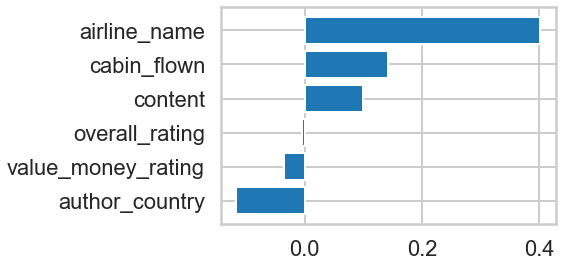

In [837]:
# plot feature importance
f_importances(test_many_linear_6['clf'].coef_[0], list(X_data_train_6.columns))

In [682]:
# pipeline with Random Forest classifier with 6 features
test_many_rf_6 = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer_6('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer_6('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f3', Pipeline([
                                    ('get', GetItemTransformer_6('author_country')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f4', Pipeline([
                                    ('get', GetItemTransformer_6('content')),
                                    ('tfidf', TfidfVectorizer(stop_words='english')),
                                    ])),
                            ('f5', Pipeline([
                                    ('get', NumberSelector_6('value_money_rating')),
                                    ])),
                            ('f6', Pipeline([
                                    ('get', NumberSelector_6('overall_rating')),
                                    ])),
                            ])),
    ('clf', RandomForestClassifier()),
    ])

In [683]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_many_rf_6 = cross_val_score(test_many_rf_6, X_data_train_6, y_data_train_6, cv=5)

# print result
print('5 KFold cross validation with Random Forest classifier: ', cv_result_many_rf_6)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/si

5 KFold cross validation with Random Forest classifier:  [0.93126591 0.93171296 0.92337963 0.91967593 0.90486111]


In [684]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_many_rf_6.mean())

Average value for model's accuracy:  0.9221791080596912


In [704]:
# fit the selected classifier with training data and predict on test
model_many_rf_6 = test_many_rf_6.fit(X_data_train_6, y_data_train_6)
predicted_many_rf_6 = model_many_rf_6.predict(X_data_test_6)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_data_test_6, predicted_many_rf_6))

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC AUC score:  0.9200808285699281


In [813]:
# print confusion matrix
print(metrics.confusion_matrix(y_data_test_6, predicted_many_rf_6))

[[3321  310]
 [ 419 5208]]


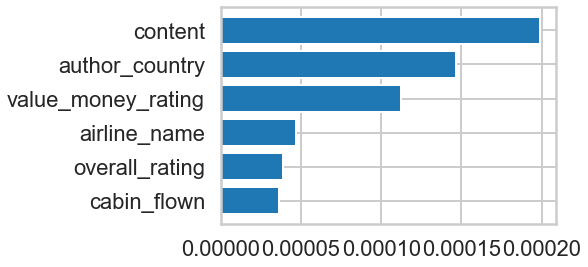

In [792]:
# plot feature importance
f_importances(test_many_rf_6['clf'].feature_importances_, list(X_data_train_6.columns))

Let's create models by including traveller type feature. But first we have to exclude all rows that don't have value for this feature.

In [685]:
data_ratings_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35609 entries, 0 to 35608
Data columns (total 21 columns):
airline_name                     35609 non-null object
link                             35609 non-null object
title                            35609 non-null object
author                           35609 non-null object
author_country                   35396 non-null object
date                             35609 non-null object
content                          35609 non-null object
aircraft                         1153 non-null object
type_traveller                   2164 non-null object
cabin_flown                      34138 non-null object
route                            2128 non-null object
overall_rating                   32275 non-null float64
seat_comfort_rating              31415 non-null float64
cabin_staff_rating               31417 non-null float64
food_beverages_rating            31020 non-null float64
inflight_entertainment_rating    28980 non-null float64
ground_se

In [686]:
df_eight = data_ratings_copy[['airline_name', 'author_country', 'content', 'type_traveller', 'cabin_flown', 'overall_rating', 'value_money_rating', 'recommended']]

In [687]:
# drop rows where 'author_country', 'cabin_flown', 'overall_rating', 'value_money_rating' columns are not empty
df_eight_cols = df_eight.dropna(subset=['author_country', 'cabin_flown', 'overall_rating', 'value_money_rating', 'type_traveller'])

In [689]:
# change float type into integer
df_eight_cols.overall_rating = df_eight_cols.overall_rating.astype(int)
df_eight_cols.value_money_rating = df_eight_cols.value_money_rating.astype(int)

/anaconda3/envs/statenv/lib/python3.6/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [690]:
df_eight_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2150 entries, 0 to 34961
Data columns (total 8 columns):
airline_name          2150 non-null object
author_country        2150 non-null object
content               2150 non-null object
type_traveller        2150 non-null object
cabin_flown           2150 non-null object
overall_rating        2150 non-null int64
value_money_rating    2150 non-null int64
recommended           2150 non-null int64
dtypes: int64(3), object(5)
memory usage: 151.2+ KB


In [691]:
# define features and labels
X_data_8 = df_eight_cols.drop('recommended', axis=1)
y_data_8 = df_eight_cols['recommended']

In [692]:
# split data into training and test set
X_data_train_8, X_data_test_8, y_data_train_8, y_data_test_8 = train_test_split(X_data_8, y_data_8, test_size=0.3, random_state=21)

In [693]:
# function to extract a column from dataframe and fit and transform it
class GetItemTransformer_8(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X_data_8, y_data_8=None):
        return self
    def transform(self, X_data_8):
        return X_data_8[self.field]

In [694]:
# function to select integer column from a dataframe
class NumberSelector_8(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X_data_8, y_data_8=None):
        return self
    def transform(self, X_data_8):
        return X_data_8[[self.field]]

In [695]:
# pipeline with LinearSVC classifier with 7 features
test_many_linear_8 = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer_8('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer_8('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f3', Pipeline([
                                    ('get', GetItemTransformer_8('author_country')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f4', Pipeline([
                                    ('get', GetItemTransformer_8('content')),
                                    ('tfidf', TfidfVectorizer(stop_words='english')),
                                    ])),
                            ('f5', Pipeline([
                                    ('get', GetItemTransformer_8('type_traveller')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f6', Pipeline([
                                    ('get', NumberSelector_8('value_money_rating')),
                                    ])),
                            ('f7', Pipeline([
                                    ('get', NumberSelector_8('overall_rating')),
                                    ])),
                            ])),
    ('clf', LinearSVC()),
    ])

In [696]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_many_linear_8 = cross_val_score(test_many_linear_8, X_data_train_8, y_data_train_8, cv=5)

# print result
print('5 KFold cross validation with LinearSVC classifier: ', cv_result_many_linear_8)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


5 KFold cross validation with LinearSVC classifier:  [0.97019868 0.96345515 0.95016611 0.97009967 0.96333333]


In [697]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_many_linear_8.mean())

Average value for model's accuracy:  0.9634505878125161


In [703]:
# fit the selected classifier with training data and predict on test
model_many_linear_8 = test_many_linear_8.fit(X_data_train_8, y_data_train_8)
predicted_many_linear_8 = model_many_linear_8.predict(X_data_test_8)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_data_test_8, predicted_many_linear_8))

ROC AUC score:  0.9445700260002329


In [835]:
test_many_linear_8_AUC_all = cross_val_score(test_many_linear_8, X_data_8, y_data_8, scoring='roc_auc', cv=5)
print(test_many_linear_8_AUC_all)
print("Average AUC score: ",  test_many_linear_8_AUC_all.mean())

[0.99290504 0.97719565 0.97721739 0.99093478 0.98886463]
Average AUC score:  0.9854234989850446


In [797]:
# print confusion matrix
print(metrics.confusion_matrix(y_data_test_8, predicted_many_linear_8))

[[332  21]
 [ 15 277]]


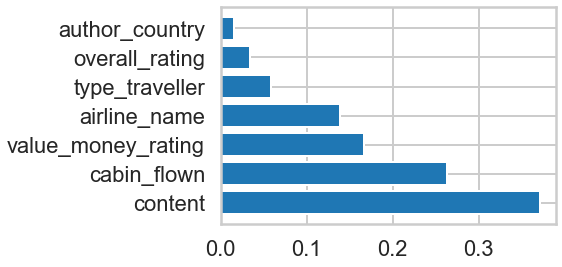

In [770]:
def f_importances_3(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# whatever your features are called
features_names = list(X_data_8.columns)
#svm_3 = LinearSVC()
#svm_3.fit(X_data_train_8, y_data_train_8)

# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importances_3(abs(test_many_linear_8['clf'].coef_[0]), feat_names)

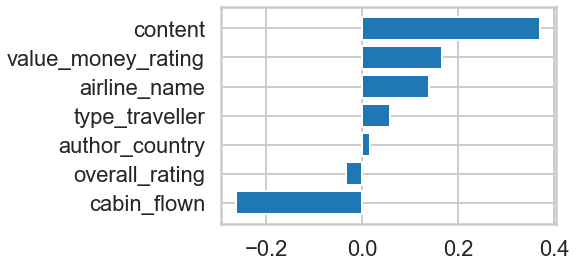

In [815]:
# plot feature importance
features_names = list(X_data_8.columns)
f_importances(test_many_linear_8['clf'].coef_[0], feat_names)

In [698]:
# pipeline with Random Forest classifier with 7 features
test_many_rf_8 = Pipeline([
    ('features', FeatureUnion([
                            ('f1', Pipeline([
                                    ('get', GetItemTransformer_8('airline_name')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f2', Pipeline([
                                    ('get', GetItemTransformer_8('cabin_flown')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f3', Pipeline([
                                    ('get', GetItemTransformer_8('author_country')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f4', Pipeline([
                                    ('get', GetItemTransformer_8('content')),
                                    ('tfidf', TfidfVectorizer(stop_words='english')),
                                    ])),
                            ('f5', Pipeline([
                                    ('get', GetItemTransformer_8('type_traveller')),
                                    ('ctvr', CountVectorizer(stop_words='english')),
                                    ])),
                            ('f6', Pipeline([
                                    ('get', NumberSelector_8('value_money_rating')),
                                    ])),
                            ('f7', Pipeline([
                                    ('get', NumberSelector_8('overall_rating')),
                                    ])),
                            ])),
    ('clf', RandomForestClassifier()),
    ])

In [699]:
# split the data into five folds, then execute the classifier pipeline on the dataset
cv_result_many_rf_8 = cross_val_score(test_many_rf_8, X_data_train_8, y_data_train_8, cv=5)

# print result
print('5 KFold cross validation with Random Forest classifier: ', cv_result_many_rf_8)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5 KFold cross validation with Random Forest classifier:  [0.91059603 0.94352159 0.87707641 0.92026578 0.92      ]


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [700]:
# compute average of CV scores
print("Average value for model's accuracy: ",  cv_result_many_rf_8.mean())

Average value for model's accuracy:  0.9142919627730963


In [831]:
# cross validation to compute roc_auc
test_many_rf_8_AUC = cross_val_score(test_many_rf_8, X_data_train_8, y_data_train_8, scoring='roc_auc', cv=5)
print(test_many_rf_8_AUC)

[0.98384683 0.9686199  0.96368146 0.97050226 0.96052456]


In [832]:
# compute average of CV scores
print("Average AUC score: ",  test_many_rf_8_AUC.mean())

Average AUC score:  0.9694350000376944


In [834]:
test_many_rf_8_AUC_all = cross_val_score(test_many_rf_8, X_data_8, y_data_8, scoring='roc_auc', cv=5)
print(test_many_rf_8_AUC_all)
print("Average AUC score: ",  test_many_rf_8_AUC_all.mean())

[0.97738482 0.97698913 0.94548913 0.98269565 0.9693559 ]
Average AUC score:  0.9703829246590286


In [702]:
# fit the selected classifier with training data and predict on test
model_many_rf_8 = test_many_rf_8.fit(X_data_train_8, y_data_train_8)
predicted_many_rf_8 = model_many_rf_8.predict(X_data_test_8)

# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_data_test_8, predicted_many_rf_8))

ROC AUC score:  0.9141070666304474


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [796]:
# print confusion matrix
print(metrics.confusion_matrix(y_data_test_8, predicted_many_rf_8))

[[325  28]
 [ 27 265]]


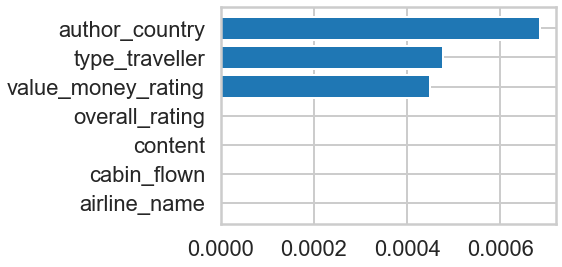

In [814]:
# plot feature importance
feat_names = ['airline_name', 'author_country', 'cabin_flown', 'content', 'overall_rating', 'type_traveller', 'value_money_rating']
f_importances(test_many_rf_8['clf'].feature_importances_, feat_names)